BUILDING A FX QUANTITATIVE SYSTEM

FX trading is one of most competitive markets in the world. Besides other financial instruments, FX makes traditional portfolio managers name it gambling as its difficulty in prediction and high volatility. 

To make it simple we have two approaches when it comes to trading, trend or contra-trend. FX it's very corrective, however when a strong trend starts caused by any macroeconomic factor you better surf the trend and not fight against it if you want to survive.

In this notebook I'll expalin my fundamental approach to FX quantitative trading. First we will simplify 45 pairs to 10 currency indices, which will allow us to observe the market dissegmented and catch easier the trending pairs and the corrective ones.

Through this notebook I'll explain step by step each process and its logic.

In [ ]:

# import libraries
from oandapyV20 import API
import oandapyV20.endpoints.instruments as instruments
from os import listdir
import pandas as pd
from pathlib import Path
import plotly.express as px
import seaborn as sns

# create a file named key.py with token = 'your_oanda_token'
import key

client = API(access_token=key.token)

In [4]:
symbols = ['AUD_CAD', 'AUD_CHF', 'AUD_HKD', 'AUD_JPY', 'AUD_NZD', 'AUD_SGD', 'AUD_USD',
           'CAD_CHF', 'CAD_HKD', 'CAD_JPY', 'CAD_SGD', 'CHF_HKD', 'CHF_JPY', 'EUR_AUD',
           'EUR_CAD', 'EUR_CHF', 'EUR_GBP', 'EUR_HKD', 'EUR_JPY', 'EUR_NZD', 'EUR_SGD',
           'EUR_USD', 'GBP_AUD', 'GBP_CAD', 'GBP_CHF', 'GBP_HKD', 'GBP_JPY', 'GBP_NZD',
           'GBP_SGD', 'GBP_USD', 'HKD_JPY', 'NZD_CAD', 'NZD_CHF', 'NZD_HKD', 'NZD_JPY',
           'NZD_SGD', 'NZD_USD', 'SGD_CHF', 'SGD_HKD', 'SGD_JPY', 'USD_CAD', 'USD_CHF',
           'USD_HKD', 'USD_JPY', 'USD_SGD'] # 45 fx pairs

path = 'db/instruments' # path where to download history data

timeframe = 'D'
lookback = 300


In order to don't charge to much our pc's RAM we'll create a local database (db) of all the symbols to be analyzed and traded. Each instrument will have it's own csv file and its timeframe folder. It will help later to backtest our model as well.

In [10]:
def db(symbols):
    for sym in symbols:
        print('Downloading '+sym+'...')
        params = { 'granularity': timeframe,'count': lookback }
        r = instruments.InstrumentsCandles(sym, params)
        r = client.request(r)
        date = r['candles'][0]['time'][0:19]
        ret = 0
        df = pd.DataFrame({'date': date, 'return': round(ret, 2)}, index=[0])
        for i in range(1, len(r['candles'])):
            date = r['candles'][i]['time'][0:19]
            #date = r['candles'][i]['time'][0:10]
            #hour = int(r['candles'][i]['time'][11:13])
            ret = (float(r['candles'][i]['mid']['c']) /
                   float(r['candles'][i]['mid']['o'])-1)*100
            #vol = round((float(r['candles'][i]['mid']['h'])/float(r['candles'][i]['mid']['l'])-1)*100, 2)
            add = pd.DataFrame(
                {'date': date, 'return': round(ret, 2)}, index=[0])
            df = pd.concat([df, add], ignore_index=True)

        Path('db/instruments/'+timeframe).mkdir(parents=True, exist_ok=True)
        df.to_csv('db/instruments/'+timeframe+'/'+sym+'.csv', index=False)


db(symbols)



Now that we have all the instruments in our folder ( ./db/instruments/'timeframe'/ ) we'll create a function to extract each currency index. The idea is simple: if we want to see the AUD movements, we'll take all the returns in the AUD pairs. I.e: AUD/CAD + AUD/JPY + 1/(EUR/AUD) + ...

In [15]:

def index(currency):
    print('Creating '+currency+'...')
    files = [k for k in listdir('db/instruments/'+timeframe) if currency in k]
    df = pd.read_csv('db/instruments/'+timeframe+'/'+files[0])
    if files[0][0:3] != currency:
        df['return'] = -df['return']
    df = df.rename(columns={'return': files[0][0:7]})
    for i in range(1, len(files)):
        df2 = pd.read_csv('db/instruments/'+timeframe+'/'+files[i])
        if files[i][0:3] != currency:
            df2['return'] = -df2['return']
        df2 = df2.rename(columns={'return': files[i][0:7]})
        df = pd.merge(df, df2, on=['date', 'date'])
    df = df.fillna(0)
    df = df.set_index('date')
    df[currency] = round(df.sum(axis=1)/len(currencies), 2)
    df = df[currency]
    Path('db/indexes/'+timeframe).mkdir(parents=True, exist_ok=True)
    df.to_csv('db/indexes/'+timeframe+'/'+currency+'.csv', index=True)


currencies = ['AUD', 'CAD', 'CHF', 'EUR',
              'GBP', 'HKD', 'JPY', 'NZD', 'SGD', 'USD']

for curr in currencies:
    index(curr)



Creating AUD...
Creating CAD...
Creating CHF...
Creating EUR...
Creating GBP...
Creating HKD...
Creating JPY...
Creating NZD...
Creating SGD...
Creating USD...


We have created the FX G10 currency indices. Meaning that now we can observe each currency by separate. Let's plot it and see the correlation between them.

[Text(0.5, 1.0, 'FX G10 Correlation Matrix\n')]

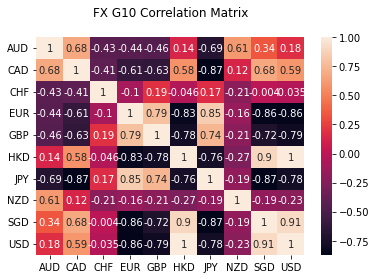

In [12]:
df = pd.read_csv('db/indexes/'+timeframe+'/'+currencies[0]+'.csv')
df[currencies[0]] = df[currencies[0]].cumsum()
for i in range(1, len(currencies)):
    df2 = pd.read_csv('db/indexes/'+timeframe+'/'+currencies[i]+'.csv')
    df2[currencies[i]] = df2[currencies[i]].cumsum()
    df = pd.merge(df, df2, on=['date', 'date'])

pd.options.plotting.backend = "plotly"
plt = df.plot(x='date', y=currencies)
plt.show()

matrix = df.corr()
hm = sns.heatmap(matrix, annot=True)
hm.set(title="FX G10 Correlation Matrix\n")

As we can oberseve 